In [1]:
! pip install evaluate sacrebleu

In [ ]:
# === Imports & Global Config (Consolidated) ===
import os, json, re, unicodedata, math, copy, shutil
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from accelerate import Accelerator
from tqdm.auto import tqdm
import evaluate
import nltk
import sacrebleu  # optional direct usage if needed
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, get_scheduler

# Download required NLTK data (safe to call multiple times; will skip if already present)
for pkg in ['punkt', 'wordnet', 'omw-1.4']:
    try:
        nltk.download(pkg, quiet=True)
    except Exception as e:
        print(f"Warning: failed to download {pkg}: {e}")

# Dataset path (define once here)
data_path = '../../data/paralel_cub_200_2011_captions_final-curated.json'
if os.path.exists(data_path):
    print(f"File found at: {data_path}")
else:
    print(f"File not found at: {data_path}")

# All downstream cells rely on the imports & data_path defined here.

File found at: ../../data/paralel_cub_200_2011_captions_FINAL_replaced.json


# Load data

In [3]:
# Text preprocessing utilities

def preprocess_text(text: str) -> str:
    """Normalize and lightly clean text.
    Steps:
    1. Unicode normalize (NFKC)
    2. Lowercase
    3. Remove URLs
    4. Remove unwanted chars (keep alnum + basic punct)
    5. Collapse whitespace
    6. Replace artifact '1212'
    """
    text = unicodedata.normalize("NFKC", text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?'-]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = text.replace("1212", " ")
    return text

In [ ]:
# Load JSON file

data_path = '../../data/paralel_cub_200_2011_captions_final-curated.json'
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Flatten the pairs
pairs = []
for item in data:
    for caption in item["captions"]:
        en = preprocess_text(caption["english"])
        idn = preprocess_text(caption["indo"])
        pairs.append((en, idn))

print(pairs[:3])

[('the medium sized bird has a dark grey color, a black downward curved beak, and long wings.', 'burung berukuran sedang ini memiliki warna abu-abu tua, paruh hitam melengkung ke bawah, dan sayap panjang.'), ('the bird is dark grey brown with a thick curved bill and a flat shaped tail.', 'burung ini berwarna coklat abu-abu tua dengan paruh tebal melengkung dan ekor berbentuk pipih.'), ('bird has brown body feathers, white breast feathers and black beak', 'burung mempunyai bulu badan berwarna coklat, bulu dada berwarna putih dan paruh berwarna hitam')]


In [5]:
print(f"Total data: {len(pairs)}")

Total data: 117880


In [6]:
# Remove empty or very short sentences
pairs = [(en, idn) for en, idn in pairs if len(en.split()) > 5 and len(idn.split()) > 5]

# Deduplicate
pairs = list(set(pairs))

print(f"Total data setelah menghapus data duplikat: {len(pairs)}")

# Take only 0.1% of data for testing
# num_samples = int(len(pairs) * 0.001)  # 0.1% dari total data
# pairs = pairs[:num_samples]

# print(f"Total data setelah menghapus data duplikat: {len(pairs)}")
# print(f"Menggunakan {num_samples} sampel (0.1% dari total data)")

Total data setelah menghapus data duplikat: 96565


In [7]:
error = "1212"
error_total = 0
for (en, idn) in pairs:
    if en.__contains__(error) or idn.__contains__(error):
        error_total += 1
print(f"data error total: {error_total}")

data error total: 0


# Train test split

In [8]:
from sklearn.model_selection import train_test_split

train_pairs, test_pairs = train_test_split(pairs, test_size=0.1, random_state=42)
train_pairs, val_pairs  = train_test_split(train_pairs, test_size=0.1111, random_state=42)

print(f"Train size: {len(train_pairs)}")
print(f"Val size: {len(val_pairs)}")
print(f"Test size: {len(test_pairs)}")

Train size: 77252
Val size: 9656
Test size: 9657


# Load model and tokenizer

In [9]:
# Load tokenizer & base model (MarianMT - en->id)
model_name = "muvazana/flan-t5-base-opus-en-id-id-en"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name, use_safetensors=True)

In [10]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, pairs, tokenizer, max_length=384):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]

        model_inputs = self.tokenizer(
            src,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            text_target=tgt
        )

        return {k: torch.tensor(v) for k, v in model_inputs.items()}

In [11]:
from torch.utils.data import DataLoader

train_dataset = TranslationDataset(train_pairs, tokenizer)
val_dataset   = TranslationDataset(val_pairs, tokenizer)
test_dataset  = TranslationDataset(test_pairs, tokenizer)


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)
test_loader  = DataLoader(test_dataset, batch_size=4)

# Grid Search Configuration

In [12]:
# Hyperparameter grid (focused)
param_grid = {
    'learning_rate': [2e-5, 3e-5],
    'batch_size': [8],        # fixed for stability
    'num_epochs': [3, 5],
    'warmup_ratio': [0.1],
    'weight_decay': [0.01]
}

grid_search_results = []
best_bleu = 0.0
best_model = None
best_params = None

# Dataloaders with fixed batch size (will be re-created inside loop for each combo)
train_loader = DataLoader(train_dataset, batch_size=param_grid['batch_size'][0], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=param_grid['batch_size'][0])

print("Grid Search Configuration:")
print("-------------------------")
for param, values in param_grid.items():
    print(f"{param}: {values}")

total_combinations = len(param_grid['learning_rate']) * len(param_grid['num_epochs'])
print(f"\nTotal kombinasi yang akan dicoba: {total_combinations}")
print("\nKonfigurasi tetap:")
print(f"- Batch size: {param_grid['batch_size'][0]}")
print(f"- Weight decay: {param_grid['weight_decay'][0]}")
print(f"- Warmup ratio: {param_grid['warmup_ratio'][0]}")

Grid Search Configuration:
-------------------------
learning_rate: [2e-05, 3e-05]
batch_size: [8]
num_epochs: [3, 5]
warmup_ratio: [0.1]
weight_decay: [0.01]

Total kombinasi yang akan dicoba: 4

Konfigurasi tetap:
- Batch size: 8
- Weight decay: 0.01
- Warmup ratio: 0.1


In [ ]:
# TRAINING UTILITIES, LAYER FREEZING, DAN GRID SEARCH LOOP (VERSI FINAL & AMAN)

accelerator = Accelerator()
device = accelerator.device
print("Using device:", device)

bleu_metric = evaluate.load("sacrebleu")
meteor_metric = evaluate.load("meteor") 

root_dir = "./gridsearch_t5_manual_experiment"
checkpoint_root = os.path.join(root_dir, "checkpoints")
best_model_dir = os.path.join(root_dir, "best_model")
os.makedirs(checkpoint_root, exist_ok=True)
os.makedirs(best_model_dir, exist_ok=True)

# KONFIGURASI RETENSI CHECKPOINT GLOBAL
RESUME_ENABLED = True
STRICT_EPOCH_MATCH = True
# Disable automatic checkpoint deletion by default (keep all checkpoints)
KEEP_LAST_N_CKPT = None  # Set to None to disable retention pruning
# =======================================================================

# File untuk persist best BLEU antar run
best_state_file = os.path.join(root_dir, 'best_global.json')

# Variabel Global untuk menahan direktori kombinasi yang AKAN dihapus (ditunda)
LAST_SUCCESSFUL_COMBO_DIR = None 


# === Definisi Fungsi Pembantu ===
def fmt_lr(lr: float) -> str:
    return f"{lr:.0e}" if lr < 1e-3 else (f"{lr:.6f}".rstrip('0').rstrip('.'))

def extract_epoch(name):
    try:
        for p in name.split('_'):
            if p.startswith('ep') and p[2:].isdigit():
                return int(p[2:])
    except Exception:
        return -1
    return -1

def save_checkpoint(model, optimizer, epoch, lr, batch_size, weight_decay, num_epochs_cfg, train_loss, val_loss, bleu, meteor, history, patience_counter, ckpt_dir):
    unwrapped = accelerator.unwrap_model(model)
    lr_tag = fmt_lr(lr)
    dir_name = (f"ckpt_lr{lr_tag}_bs{batch_size}_wd{weight_decay}_maxep{num_epochs_cfg}_ep{epoch}"\
                f"_tl{train_loss:.4f}_vl{val_loss:.4f}_bleu{bleu:.2f}_meteor{meteor:.2f}")
    full = os.path.join(ckpt_dir, dir_name)
    os.makedirs(full, exist_ok=True)
    state = {
        'epoch': epoch,
        'model_state_dict': unwrapped.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'learning_rate': lr,
        'batch_size': batch_size,
        'weight_decay': weight_decay,
        'configured_num_epochs': num_epochs_cfg,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'bleu': bleu,
        'meteor': meteor,
        'history': history,
        'patience_counter': patience_counter
    }
    torch.save(state, os.path.join(full, 'checkpoint.pt'))
    print(f"Saved checkpoint: {full}")

# Ganti fungsi load_latest_checkpoint di Cell 11 Anda dengan kode ini:

def load_latest_checkpoint(model, optimizer, ckpt_dir, lr, batch_size, weight_decay, num_epochs_cfg):
    if not RESUME_ENABLED or not os.path.isdir(ckpt_dir):
        return None
    lr_tag = fmt_lr(lr)
    prefix = f"ckpt_lr{lr_tag}_bs{batch_size}_wd{weight_decay}_maxep{num_epochs_cfg}_ep" if STRICT_EPOCH_MATCH else f"ckpt_lr{lr_tag}_bs{batch_size}_wd{weight_decay}_"
    candidates = [d for d in os.listdir(ckpt_dir) if d.startswith(prefix)]
    if not candidates:
        return None
    
    candidates.sort(key=lambda x: extract_epoch(x), reverse=True)
    
    for cand in candidates:
        path = os.path.join(ckpt_dir, cand, 'checkpoint.pt')
        try:
            # === PERBAIKAN: Set weights_only=False untuk kompatibilitas mundur ===
            # Ini mengizinkan PyTorch memuat file lama.
            ckpt = torch.load(path, map_location='cpu', weights_only=False)
            
            if STRICT_EPOCH_MATCH and ckpt.get('configured_num_epochs') != num_epochs_cfg:
                continue
            model.load_state_dict(ckpt['model_state_dict'])
            optimizer.load_state_dict(ckpt['optimizer_state_dict'])
            print(f"Resumed from checkpoint: {cand}")
            return ckpt
        except Exception as e:
            # Tambahkan pengecualian spesifik jika gagal loading
            if "Unsupported global" in str(e) or "WeightsUnpickler error" in str(e):
                print(f"Failed to load {cand} due to PyTorch safety change. Skipping resume for this checkpoint.")
            else:
                print(f"Failed to load {cand}: {e}")
            continue
    return None

def save_best_model(model, tokenizer, params, metrics, save_dir):
    # Do NOT wipe existing best_model_dir contents. Keep previous best snapshots intact.
    unwrapped = accelerator.unwrap_model(model)
    lr_tag = fmt_lr(params['learning_rate'])
    dir_name = (f"best_lr{lr_tag}_bs{params['batch_size']}_wd{params['weight_decay']}_maxep{params['num_epochs']}_ep{params['epoch']}"\
                f"_tl{metrics['train_loss']:.4f}_vl{metrics['val_loss']:.4f}_bleu{metrics['bleu']:.2f}_meteor{metrics['meteor']:.2f}")
    dest = os.path.join(save_dir, dir_name)
    os.makedirs(dest, exist_ok=True)
    unwrapped.save_pretrained(dest)
    tokenizer.save_pretrained(dest)
    with open(os.path.join(dest, 'best_params.json'), 'w') as f:
        json.dump({'hyperparameters': params, 'metrics': metrics}, f, indent=4)
    print(f"New best model saved to: {dest}")
# =========================================================================

# === Early Stopping Config (VAL LOSS based) ===
early_stopping_patience = 2              
min_val_loss_improvement = 0.0002         
min_bleu_improvement = 0.2               

bleu_scores = {}
training_results = []

if os.path.exists(best_state_file):
    try:
        with open(best_state_file, 'r') as f:
            saved_best = json.load(f)
        best_bleu = saved_best.get('best_bleu', 0.0)
        best_params = saved_best.get('best_params', {})
        print(f"Loaded persisted best_bleu={best_bleu:.2f}")
    except Exception as e:
        print(f"Failed to load persisted best: {e}")
        if 'best_bleu' not in globals():
            best_bleu = 0.0
        if 'best_params' not in globals():
            best_params = {}
else:
    if 'best_bleu' not in globals():
        best_bleu = 0.0
    if 'best_params' not in globals():
        best_params = {}

if 'best_model' not in globals():
    best_model = None

# === Layer Freezing & Gradient Accumulation Configuration ===
NUM_ENCODER_LAYERS_TO_TRAIN = 2
NUM_DECODER_LAYERS_TO_TRAIN = 6
gradient_accumulation_steps = 2 # EFEKTIF BATCH SIZE = batch_size * 2

# Loop grid search dimulai
for lr in param_grid['learning_rate']:
    for batch_size in param_grid['batch_size']:
        for num_epochs in param_grid['num_epochs']:
            for weight_decay in param_grid['weight_decay']:\
                
                # Variabel ini menampung folder kombinasi sebelumnya yang siap dihapus.
                folder_to_delete_on_success = LAST_SUCCESSFUL_COMBO_DIR
                
                # Reset pointer global sebelum memulai iterasi baru.
                LAST_SUCCESSFUL_COMBO_DIR = None
                
                lr_tag = fmt_lr(lr)
                print(f"\n=== Training: lr={lr} (tag {lr_tag}), batch_size={batch_size}, epochs={num_epochs}, weight_decay={weight_decay} ===")
                print(f"   >>> Gradient Accumulation Steps: {gradient_accumulation_steps} (Effective BS: {batch_size * gradient_accumulation_steps})")
                
                # Muat model dasar (model akan diinisiasi ulang per kombinasi)
                model = AutoModelForSeq2SeqLM.from_pretrained(model_name, use_safetensors=True)
                
                # <<< PERBAIKAN FATAL OOM: AKTIVASI GRADIENT CHECKPOINTING >>>
                model.gradient_checkpointing_enable() 
                print("Gradient Checkpointing diaktifkan.")
                # ==========================================================

                # === Layer Freezing Implementation (Selective) ===
                
                # 1. Membekukan Shared Embedding Layer
                if hasattr(model, 'shared') and model.shared is not None:
                    for param in model.shared.parameters():
                        param.requires_grad = False
                    print("Shared Embedding Layer frozen.")

                # 2. Membekukan Layer Encoder Bawah
                if hasattr(model.encoder, 'block'):
                    num_encoder_layers = len(model.encoder.block)
                    layers_to_freeze_enc = num_encoder_layers - NUM_ENCODER_LAYERS_TO_TRAIN
                    for i in range(layers_to_freeze_enc):
                        for param in model.encoder.block[i].parameters():
                            param.requires_grad = False
                    print(f"Encoder: {layers_to_freeze_enc} bottom layers frozen, {NUM_ENCODER_LAYERS_TO_TRAIN} top layers trainable.")

                # 3. Membekukan Layer Decoder Bawah
                if hasattr(model.decoder, 'block'):
                    num_decoder_layers = len(model.decoder.block)
                    layers_to_freeze_dec = num_decoder_layers - NUM_DECODER_LAYERS_TO_TRAIN
                    for i in range(layers_to_freeze_dec):
                        for param in model.decoder.block[i].parameters():
                            param.requires_grad = False
                    print(f"Decoder: {layers_to_freeze_dec} bottom layers frozen, {NUM_DECODER_LAYERS_TO_TRAIN} top layers trainable.")
                # =======================================

                # Optimizer sekarang hanya akan menginisiasi parameter yang tidak dibekukan
                optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
                
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size)
                num_training_steps = num_epochs * len(train_loader)
                num_warmup_steps = int(param_grid['warmup_ratio'][0] * num_training_steps)
                scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)
                
                model, optimizer, train_loader, val_loader, scheduler = accelerator.prepare(model, optimizer, train_loader, val_loader, scheduler)
                
                combo_ckpt_dir = os.path.join(checkpoint_root, f"lr{lr_tag}_bs{batch_size}_wd{weight_decay}_maxep{num_epochs}")
                os.makedirs(combo_ckpt_dir, exist_ok=True)
                print(f"Checkpoint directory kombinasi: {combo_ckpt_dir}")
                
                loaded_ckpt = load_latest_checkpoint(model, optimizer, combo_ckpt_dir, lr, batch_size, weight_decay, num_epochs)
                
                # --- PENGATURAN STARTING EPOCH ---
                if loaded_ckpt:
                    starting_epoch = loaded_ckpt['epoch']
                else:
                    starting_epoch = 0
                
                if starting_epoch >= num_epochs:
                    print(f"Semua epoch ({num_epochs}) telah selesai sebelumnya. Melewati kombinasi ini.")
                    # Pindahkan folder ini ke antrian global (untuk dihapus di iterasi berikutnya)
                    LAST_SUCCESSFUL_COMBO_DIR = combo_ckpt_dir
                    continue # Lanjut ke kombinasi berikutnya
                
                # Initialize history and metrics 
                history = loaded_ckpt.get('history', {
                    'learning_rate': lr, 'batch_size': batch_size, 'weight_decay': weight_decay, 'num_epochs': num_epochs,
                    'train_losses': [], 'val_losses': [], 'bleu_scores': [], 'meteor_scores': []
                }) if loaded_ckpt else {
                    'learning_rate': lr, 'batch_size': batch_size, 'weight_decay': weight_decay, 'num_epochs': num_epochs,
                    'train_losses': [], 'val_losses': [], 'bleu_scores': [], 'meteor_scores': []
                }
                patience_counter = loaded_ckpt.get('patience_counter', 0) if loaded_ckpt else 0
                best_combo_bleu = max(history['bleu_scores']) if history['bleu_scores'] else loaded_ckpt.get('bleu', 0.0) if loaded_ckpt else 0.0
                best_val_loss = min(history['val_losses']) if history['val_losses'] else float('inf')


                best_state_dict = None
                
                for epoch in range(starting_epoch, num_epochs):
                    model.train()
                    total_loss = 0.0
                    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
                    
                    torch.cuda.empty_cache() 
                    
                    for step, batch in enumerate(progress_bar):
                        
                        is_final_step = (step + 1) % gradient_accumulation_steps == 0 or step == len(train_loader) - 1
                        
                        outputs = model(**batch)
                        loss = outputs.loss
                        
                        # === Gradient Accumulation Logic ===
                        loss_for_backward = loss / gradient_accumulation_steps
                        accelerator.backward(loss_for_backward)
                        
                        total_loss += loss.item() 
                        
                        if is_final_step:
                            optimizer.step()
                            scheduler.step()
                            optimizer.zero_grad()
                        
                        progress_bar.set_postfix(loss=f"{loss.item():.4f}", eff_bs=f"{batch_size * gradient_accumulation_steps}")

                    avg_train_loss = total_loss / max(1, len(train_loader))
                    
                    model.eval()
                    val_loss = 0.0
                    all_preds, all_labels = [], []
                    with torch.no_grad():
                        for batch in val_loader:
                            outputs = model(**batch)
                            v_loss = outputs.loss
                            val_loss += v_loss.item()
                            
                            gen_tokens = model.generate(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], max_length=tokenizer.model_max_length)
                            
                            preds = tokenizer.batch_decode(gen_tokens, skip_special_tokens=True)
                            labels = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
                            
                            all_preds.extend(preds)
                            all_labels.extend([[l] for l in labels])
                    
                    avg_val_loss = val_loss / max(1, len(val_loader))
                    val_bleu = bleu_metric.compute(predictions=all_preds, references=all_labels)['score']
                    val_meteor = meteor_metric.compute(predictions=all_preds, references=all_labels)['meteor']
                    
                    history['train_losses'].append(avg_train_loss)
                    history['val_losses'].append(avg_val_loss)
                    history['bleu_scores'].append(val_bleu)
                    history['meteor_scores'].append(val_meteor)
                    
                    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val BLEU: {val_bleu:.2f} | Val METEOR: {val_meteor:.2f}")

                    save_checkpoint(model, optimizer, epoch+1, lr, batch_size, weight_decay, num_epochs, avg_train_loss, avg_val_loss, val_bleu, val_meteor, history, patience_counter, combo_ckpt_dir)

                    # --- Update best BLEU per-kombinasi (combo) ---
                    if val_bleu > best_combo_bleu + 1e-9:
                        improvement_bleu = val_bleu - best_combo_bleu
                        best_combo_bleu = val_bleu
                        best_state_dict = copy.deepcopy(accelerator.unwrap_model(model).state_dict())
                        # Only persist to the GLOBAL best_model_dir if this combo's best exceeds the persisted global best
                        if best_combo_bleu > best_bleu:
                            # Update global best and persist model + metadata
                            best_bleu = best_combo_bleu
                            best_model = copy.deepcopy(best_state_dict)
                            best_params = {'learning_rate': lr,'batch_size': batch_size,'num_epochs': num_epochs,'weight_decay': weight_decay,'bleu_score': best_combo_bleu,'meteor_score': val_meteor}
                            try:
                                save_best_model(
                                    model, tokenizer,
                                    params={'learning_rate': lr,'batch_size': batch_size,'num_epochs': num_epochs,'weight_decay': weight_decay,'epoch': epoch+1},
                                    metrics={'train_loss': avg_train_loss,'val_loss': avg_val_loss,'bleu': val_bleu,'meteor': val_meteor},
                                    save_dir=best_model_dir,
                                )
                                # Persist state
                                with open(best_state_file, 'w') as f:
                                    json.dump({'best_bleu': best_bleu, 'best_params': best_params}, f, indent=4)
                                print(f"Persisted new global best BLEU: {best_bleu:.2f}")
                            except Exception as e:
                                print(f"Failed to persist best BLEU or save model: {e}")

                    # --- Early stopping berbasis val loss ---
                    if best_val_loss == float('inf'):
                        best_val_loss = avg_val_loss
                        patience_counter = 0
                        print(f"[ValLoss] Baseline set to {best_val_loss:.4f}")
                    else:
                        loss_diff = best_val_loss - avg_val_loss
                        if loss_diff >= min_val_loss_improvement:
                            best_val_loss = avg_val_loss
                            patience_counter = 0
                            print(f"[ValLoss] Improved by {loss_diff:.4f} (>= {min_val_loss_improvement}) -> reset patience. New best {best_val_loss:.4f}")
                        elif avg_val_loss < best_val_loss:
                            best_val_loss = avg_val_loss
                            patience_counter += 1
                            print(f"[ValLoss] Minor improvement {loss_diff:.4f} (< {min_val_loss_improvement}). Patience {patience_counter}/{early_stopping_patience}")
                        else:
                            patience_counter += 1
                            print(f"[ValLoss] No improvement (delta {-loss_diff:.4f}). Patience {patience_counter}/{early_stopping_patience}")

                    if patience_counter >= early_stopping_patience and epoch < num_epochs - 1:
                        print("Early stopping triggered (val loss stagnation).\n")
                        break
                
                # --- ANTRIAN PEMBERSIHAN: Tandai folder ini untuk dihapus di iterasi berikutnya ---
                # Disabled: keep combo directories intact
                LAST_SUCCESSFUL_COMBO_DIR = combo_ckpt_dir 
                # --- SELESAI ---

                training_results.append({
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'num_epochs': num_epochs,
                    'weight_decay': weight_decay,
                    'best_bleu': best_combo_bleu,
                    'final_bleu': history['bleu_scores'][-1] if history['bleu_scores'] else 0.0,
                    'train_losses': history['train_losses'],
                    'val_losses': history['val_losses'],
                    'bleu_scores': history['bleu_scores'],
                    'meteor_scores': history['meteor_scores'],
                    'best_epoch': (history['bleu_scores'].index(best_combo_bleu)+1) if history['bleu_scores'] else None,
                    'final_train_loss': history['train_losses'][-1] if history['train_losses'] else None,
                    'final_val_loss': history['val_losses'][-1] if history['val_losses'] else None
                })
                bleu_scores[f"lr={lr}, bs={batch_size}, epochs={num_epochs}, wd={weight_decay}"] = best_combo_bleu

print("\nBLEU Scores for each combination:")
print("--------------------------------")
sorted_scores = sorted(bleu_scores.items(), key=lambda x: x[1], reverse=True)
for params, score in sorted_scores:
    print(f"{params} | BLEU Score: {score:.2f}")

best_subdirs = [d for d in os.listdir(best_model_dir) if os.path.isdir(os.path.join(best_model_dir, d))]
best_model_loaded = None
if best_subdirs:
    selected = best_subdirs[0]
    path = os.path.join(best_model_dir, selected)
    print(f"Best model folder: {path}")
    best_model_loaded = AutoModelForSeq2SeqLM.from_pretrained(path, use_safetensors=True)
    if torch.cuda.is_available():
        best_model_loaded = best_model_loaded.to('cuda')
else:
    print("No best model directory found yet.")

Using device: cuda


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loaded persisted best_bleu=53.66

=== Training: lr=2e-05 (tag 2e-05), batch_size=8, epochs=3, weight_decay=0.01 ===
   >>> Gradient Accumulation Steps: 2 (Effective BS: 16)
Gradient Checkpointing diaktifkan.
Shared Embedding Layer frozen.
Encoder: 11 bottom layers frozen, 1 top layers trainable.
Decoder: 10 bottom layers frozen, 2 top layers trainable.
Checkpoint directory kombinasi: ./gridsearch_t5_manual_experiment\checkpoints\lr2e-05_bs8_wd0.01_maxep3
Resumed from checkpoint: ckpt_lr2e-05_bs8_wd0.01_maxep3_ep3_tl0.0856_vl0.0576_bleu41.96_meteor0.75
Semua epoch (3) telah selesai sebelumnya. Melewati kombinasi ini.

=== Training: lr=2e-05 (tag 2e-05), batch_size=8, epochs=5, weight_decay=0.01 ===
   >>> Gradient Accumulation Steps: 2 (Effective BS: 16)
Gradient Checkpointing diaktifkan.
Shared Embedding Layer frozen.
Encoder: 11 bottom layers frozen, 1 top layers trainable.
Decoder: 10 bottom layers frozen, 2 top layers trainable.
Checkpoint directory kombinasi: ./gridsearch_t5_manual

Epoch 5/5:   0%|          | 0/9657 [00:00<?, ?it/s]

c:\Users\USER\miniconda3\envs\nmt-env\Lib\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Epoch 5/5 | Train Loss: 0.0571 | Val Loss: 0.0402 | Val BLEU: 55.26 | Val METEOR: 0.81
Saved checkpoint: ./gridsearch_t5_manual_experiment\checkpoints\lr3e-05_bs8_wd0.01_maxep5\ckpt_lr3e-05_bs8_wd0.01_maxep5_ep5_tl0.0571_vl0.0402_bleu55.26_meteor0.81
New best model saved to: ./gridsearch_t5_manual_experiment\best_model\best_lr3e-05_bs8_wd0.01_maxep5_ep5_tl0.0571_vl0.0402_bleu55.26_meteor0.81
Persisted new global best BLEU: 55.26
[ValLoss] Improved by 0.0039 (>= 0.0002) -> reset patience. New best 0.0402

BLEU Scores for each combination:
--------------------------------
lr=3e-05, bs=8, epochs=5, wd=0.01 | BLEU Score: 55.26
Best model folder: ./gridsearch_t5_manual_experiment\best_model\best_lr2e-05_bs8_wd0.01_maxep3_ep2_tl0.1222_vl0.0740_bleu30.09_meteor0.70


In [14]:
import torch

# Free up GPU memory
torch.cuda.empty_cache()

# Training Results Analysis


Training Results Summary:
------------------------


,Learning Rate,Epochs,Best Epoch,Final Train Loss,Final Val Loss,Best BLEU Score,Final BLEU Score
0,0.00003,5,5,0.057109,0.040156,55.258881,55.258881


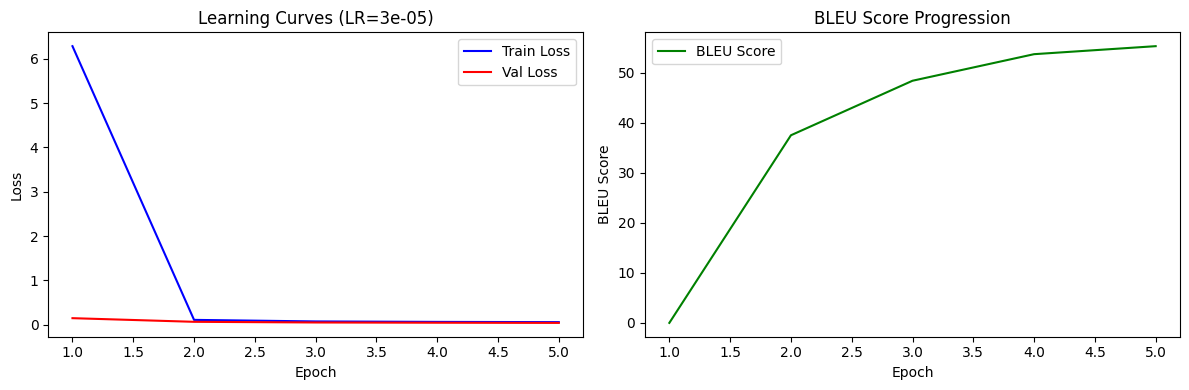


Best Model Parameters (from global best BLEU):
--------------------------------------------
learning_rate: 3e-05
batch_size: 8
num_epochs: 5
weight_decay: 0.01
bleu_score: 55.25888130873169
meteor_score: 0.8147930711694302

Daftar BLEU per kombinasi (urut skor):
lr=3e-05, bs=8, epochs=5, wd=0.01 -> 55.26

Global Best BLEU: 55.26


In [15]:
# Buat DataFrame untuk hasil training
results_df = pd.DataFrame([
    {
        'Learning Rate': res['learning_rate'],
        'Epochs': res['num_epochs'],
        'Best Epoch': res['best_epoch'],
        'Final Train Loss': res['final_train_loss'],
        'Final Val Loss': res['final_val_loss'],
        'Best BLEU Score': res['best_bleu'],
        'Final BLEU Score': res['final_bleu']
    }
    for res in training_results
])

if results_df.empty:
    print("Tidak ada hasil training.")
else:
    # Sort berdasarkan BLEU Score terbaik
    results_df = results_df.sort_values('Best BLEU Score', ascending=False)

    # Tampilkan tabel
    print("\nTraining Results Summary:")
    print("------------------------")
    display(results_df)

    # Ambil baris best BLEU
    best_row = results_df.iloc[0]

    # Cari dict asli yang cocok
    best_result = None
    for r in training_results:
        if (r['learning_rate'] == best_row['Learning Rate'] and
            r['num_epochs'] == best_row['Epochs'] and
            abs(r['best_bleu'] - best_row['Best BLEU Score']) < 1e-6):
            best_result = r
            break

    if best_result is None:
        print("Peringatan: best_result tidak ditemukan di training_results.")
    else:
        plt.figure(figsize=(12, 4))
        # Plot 1: Training & Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, len(best_result['train_losses'])+1), best_result['train_losses'], 'b-', label='Train Loss')
        plt.plot(range(1, len(best_result['val_losses'])+1), best_result['val_losses'], 'r-', label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Learning Curves (LR={best_result["learning_rate"]})')
        plt.legend()

        # Plot 2: BLEU progression
        plt.subplot(1, 2, 2)
        plt.plot(range(1, len(best_result['bleu_scores'])+1), best_result['bleu_scores'], 'g-', label='BLEU Score')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU Score')
        plt.title('BLEU Score Progression')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("\nBest Model Parameters (from global best BLEU):")
        print("--------------------------------------------")
        if 'best_params' in globals() and best_params:
            for param, value in best_params.items():
                print(f"{param}: {value}")
        else:
            print("best_params belum tersedia atau kosong.")

    # Rekap tambahan semua kombinasi
    print("\nDaftar BLEU per kombinasi (urut skor):")
    for (k, v) in sorted(bleu_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{k} -> {v:.2f}")
    print(f"\nGlobal Best BLEU: {best_bleu:.2f}")

In [16]:
# Test the best model
test_text = "this bird has wings that are brown and has a big bill"
inputs = tokenizer(test_text, return_tensors="pt")

if torch.cuda.is_available():
    inputs = {k: v.to('cuda') for k, v in inputs.items()}

translated_tokens = best_model_loaded.generate(**inputs, forced_bos_token_id=tokenizer.convert_tokens_to_ids(">>id<<"))
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

print("\nTest Translation with Best Model:")
print(f"Original: {test_text}")
print(f"Translated: {translated_text}")


Test Translation with Best Model:
Original: this bird has wings that are brown and has a big bill
Translated: burung ini mempunyai sayap yang berwarna coklat dan mempunyai paruh yang besar.


# Save Best Model

In [17]:
# Save best model from in-memory state_dict (avoid re-downloading base if not needed)
if best_model is None:
    raise ValueError("best_model belum tersedia. Jalankan training section terlebih dahulu.")

_temp_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, use_safetensors=True)
_temp_model.load_state_dict(best_model)

# UBAH PATH PENYIMPANAN KE KAGGLE WORKING DIR
save_dir = "../../data/bestmodel"
os.makedirs(save_dir, exist_ok=True)
_temp_model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

with open(os.path.join(save_dir, 'hyperparameters.json'), 'w') as f:
    json.dump(best_params, f, indent=4)

print(f"Best model saved to: {save_dir}")
print(f"Best BLEU score: {best_params['bleu_score']:.2f}")
print("Best hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

del _temp_model  # free memory

Best model saved to: ../../data/bestmodel
Best BLEU score: 55.26
Best hyperparameters:
learning_rate: 3e-05
batch_size: 8
num_epochs: 5
weight_decay: 0.01
bleu_score: 55.25888130873169
meteor_score: 0.8147930711694302
